In [1]:
!pip install eli5

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
from sklearn.base import ClassifierMixin
import eli5
from eli5.sklearn import PermutationImportance

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

%matplotlib inline

/Users/mayeshasoshi/opt/anaconda3/lib/python3.9/site-packages/seaborn/_statistics.py:31: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.21.5)
  from scipy.stats import gaussian_kde


In [3]:
# Load dataset
df_individual_reverse = pd.read_csv('df_individual_reverse.csv')
df_individual_reverse = df_individual_reverse.drop('Unnamed: 0', axis = 1)

# Create X and y variables
X_individual_reverse = df_individual_reverse.drop(['Winner', 'match', 'Year'], axis = 1)
y_individual_reverse = df_individual_reverse['Winner']

In [4]:
df_individual_reverse.head()

,match,GK Home,GK Away,FW Home,FW Away,MF Home,MF Away,DF Home,DF Away,backup Home,backup Away,Year,Winner
0,South Africa-Mexico,72.000,71.0,65.000,74.175,69.673,68.382,69.282,74.333,63.410,65.504,2010,1
1,Mexico-South Africa,71.000,72.0,74.175,65.000,68.382,69.673,74.333,69.282,65.504,63.410,2010,1
2,Uruguay-France,81.000,88.0,77.667,73.561,77.264,77.671,76.000,78.333,65.269,66.197,2010,1
3,France-Uruguay,88.000,81.0,73.561,77.667,77.671,77.264,78.333,76.000,66.197,65.269,2010,1
4,South Korea-Greece,65.556,74.0,70.852,73.667,65.556,70.750,66.037,75.667,64.111,63.917,2010,2


In [5]:
# We seperate the test data. We will not touch it. It will be used to compare different models.
X_train, X_test, y_train, y_test = train_test_split(X_individual_reverse, y_individual_reverse, test_size=0.25, random_state = 109)

In [6]:
''' Dictiionary for models in the form:
    {model1: {mse_acc : ..., test_acc: ..., model_func: ...}, 
    model2: ..., ...}
'''

model_dic = {}

In [7]:
X_train.head()

,GK Home,GK Away,FW Home,FW Away,MF Home,MF Away,DF Home,DF Away,backup Home,backup Away
405,83.0,78.0,86.667,75.879,82.250,77.25,83.000,79.333,75.083,72.000
63,74.0,72.0,71.711,79.667,75.817,81.00,69.089,87.333,65.867,65.917
126,76.0,72.0,80.333,79.667,71.875,81.00,73.583,87.333,66.833,65.917
378,84.0,69.0,75.667,66.333,79.250,74.00,78.667,74.333,74.853,65.229
257,73.0,73.0,74.000,83.333,77.750,83.00,75.000,85.000,63.167,68.439


In [8]:
y_train.head()

405    2
63     0
126    0
378    1
257    1
Name: Winner, dtype: int64


## <div class='exercise'>First Model: Logistic Regression with Three Independent Classes</div> 

In [9]:
LR = LogisticRegression(max_iter = 10000, fit_intercept = False)
LR.fit(X_train, y_train)
LR_predict_proba = LR.predict_proba(X_train)
LR_predict_proba = pd.DataFrame(LR_predict_proba, columns = ['0', '1', '2'])
LR_pred = pd.Series(LR.predict(X_train), name = 'Winner')

In [10]:
accuracy_score(LR_pred,y_train)

0.5544871794871795

In [11]:
CV1 = cross_validate(LR, X_train, y_train, cv=5, scoring = 'accuracy', return_train_score = True)
print(CV1)
print(CV1['train_score'].mean())
print(CV1['test_score'].mean())

{'fit_time': array([0.12158012, 0.07744288, 0.03654194, 0.02941012, 0.0305891 ]), 'score_time': array([0.00308299, 0.00155091, 0.00140095, 0.00141001, 0.00143194]), 'test_score': array([0.53968254, 0.50793651, 0.51612903, 0.51612903, 0.59677419]), 'train_score': array([0.562249  , 0.57831325, 0.576     , 0.576     , 0.548     ])}
0.5681124497991968
0.5353302611367127


In [12]:
accuracy_score(LR.predict(X_test),y_test)

0.5288461538461539

In [13]:
MODELS = pd.DataFrame([['Logistic Regression', accuracy_score(LR_pred,y_train), accuracy_score(LR.predict(X_test),y_test)]], columns = ['Model', 'Train Score', 'Test Score'])
display(MODELS)

,Model,Train Score,Test Score
0,Logistic Regression,0.554,0.529


In [14]:
MODEL_NAME = ['Logistic Regression']
TRAIN_SCORE = [accuracy_score(LR_pred,y_train)]
TEST_SCORE = [accuracy_score(LR.predict(X_test),y_test)]

## <div class='exercise'>Second Model: Threshold Model (We create it from scratch)</div> 

In [15]:
def new_dummies(y):
    '''
    given a response variable that takes values 0,1,2
    returns two dummies y_01 and y_12
    y_01: 0 if y == 0; 1 if y== 1 or 2
    y_12: 0 if y==0 or 1; 1 if y==2
    '''
    y_01 = y.copy()
    y_01 = y_01.replace(2, 1)
    
    y_12 = y.copy()
    y_12 = y_12.replace(1,0)
    y_12 = y_12.replace(2,1)
    return y_01, y_12

In [16]:
class ThresholdModel(ClassifierMixin):
    def __init__(self, threshold):
        self.threshold = threshold
        self.func = None
        self.func_proba = None
        
    def fit(self, X, y):
        threshold = self.threshold
        y_01, y_12 = new_dummies(y)
        LR_01 = LogisticRegression(max_iter = 16000)
        LR_01.fit(X, y_01)
        LR_12 = LogisticRegression(max_iter = 16000)
        LR_12.fit(X, y_12)
            
        def func_proba(X_new):
            pred_01 = pd.DataFrame(LR_01.predict_proba(X_new), columns = ['0', '12'])
            pred_12 = pd.DataFrame(LR_12.predict_proba(X_new), columns = ['01', '2'])
            probs = pred_01.copy().drop('12', axis=1)
            probs['1'] = pred_12['01'] - pred_01['0']
            probs['2'] = pred_12['2']
            
            return probs
            
        self.func_proba = func_proba
        
        def threshold_func(X_new):
            pred = self.func_proba(X_new)
            threshold = self.threshold
            pred.loc[pred['0'] - pred['2'] > threshold, 'Win'] = 0
            pred.loc[pred['2'] - pred['0']> threshold, 'Win'] = 2
            pred = pred.fillna(1)

            return pred['Win']
            
        self.func = threshold_func
        
            
    def predict(self, X):
        return self.func(X)
    
    def predict_proba(self, X):
        return self.func_proba(X)
    
    def get_params(self, deep = False):
        return {'threshold': self.threshold}
    
    def set_params(self, value):
        setattr(self, threshold, value)
        return self

In [17]:
model2_options = []
model2_train_accuracies = []
model2_val_accuracies = []
thresholds = []
for i in range(0,100):
    thresholds.append(i/1000)
for threshold in thresholds:
    predictor=ThresholdModel(threshold)
    CV2 = cross_validate(predictor, X_train, y_train, cv=5, return_train_score=True, scoring = 'accuracy')
    model2_options.append(predictor)
    model2_train_accuracies.append(CV2['train_score'].mean())
    model2_val_accuracies.append(CV2['test_score'].mean())

Text(0, 0.5, 'Accuracy')

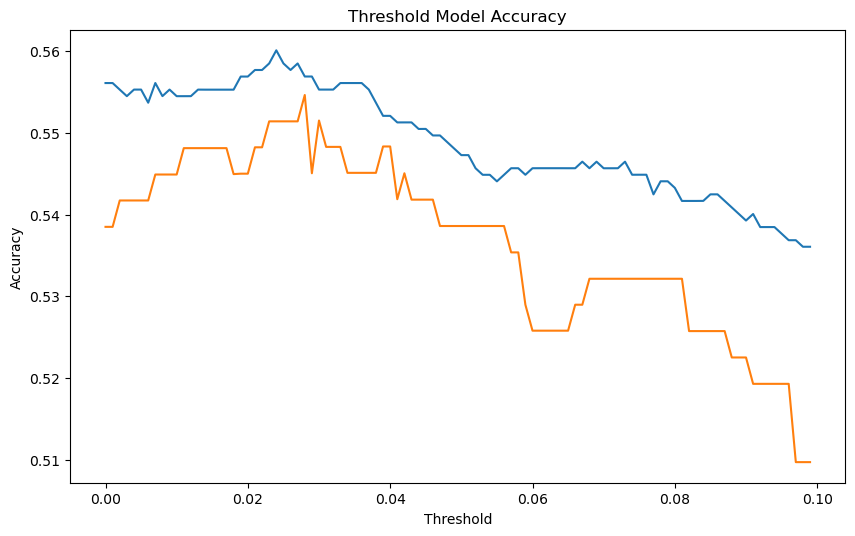

In [18]:
plt.figure(figsize=(10,6), dpi=100)
plt.plot(thresholds, model2_train_accuracies)
plt.plot(thresholds, model2_val_accuracies)
plt.title('Threshold Model Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')

In [19]:
# Find the best threshold
print(f'Train Accuracy:', round(np.max(model2_train_accuracies), 4))
print(f'Validation Accuracy:', round(np.max(model2_val_accuracies), 4))

Train Accuracy: 0.5601
Validation Accuracy: 0.5546


In [20]:
# Find the best threshold index
print(f'Train Index:', np.argmax(model2_train_accuracies))
print(f'Validation Index:', np.argmax(model2_val_accuracies))

Train Index: 24
Validation Index: 28


In [21]:
# Train the best model
best_threshold = (np.argmax(model2_val_accuracies) + 1)/1000
best_model2 = ThresholdModel(best_threshold)
best_model2.fit(X_train, y_train)
print(f'Threshold Model Best Train Accuracy:', accuracy_score(best_model2.predict(X_train), y_train))
print(f'Threshold Model Best Test Accuracy:', accuracy_score(best_model2.predict(X_test), y_test))

Threshold Model Best Train Accuracy: 0.5544871794871795
Threshold Model Best Test Accuracy: 0.5288461538461539


In [22]:
MODEL_NAME.append('Threshold = ' + str(best_threshold))
TRAIN_SCORE.append(accuracy_score(best_model2.predict(X_train), y_train))
TEST_SCORE.append(accuracy_score(best_model2.predict(X_test), y_test))

## <div class='exercise'>Third Model: Decision Tree</div> 

Text(0.5, 1.0, 'Depth vs. Accuracy in Train Data - Zoomed in')

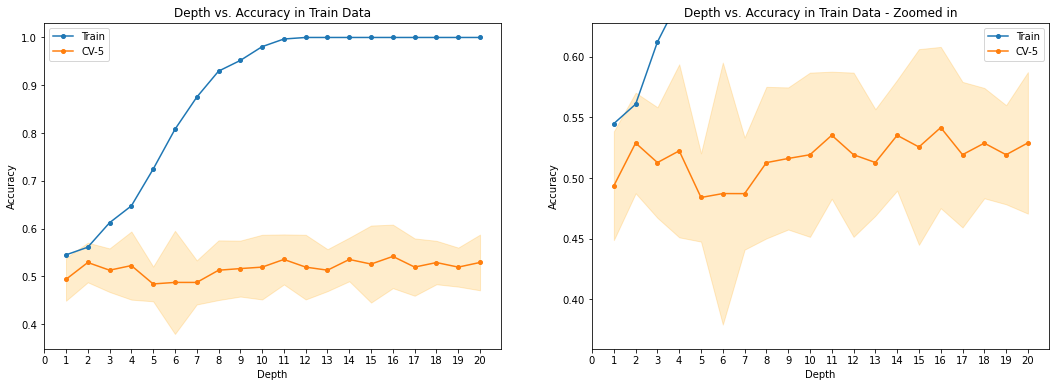

In [23]:
cvmeans = []
cvstds = []
train_scores = []
for d in range(1,21):
    dtree = DecisionTreeClassifier(max_depth = d, criterion = 'gini')
    dtree.fit(X_train, y_train)
    train_scores.append(dtree.score(X_train, y_train))
    cvscores = cross_val_score(dtree, X_train, y_train, cv=5)
    cvmeans.append(cvscores.mean())
    cvstds.append(cvscores.std())

cvmeans = pd.Series(cvmeans)
cvstds = pd.Series(cvstds)   

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (18,6))
axes = axes.ravel()

for ax in axes:
    ax.plot(range(1, 21), train_scores, label = "Train", marker = 'o', markersize = 4)
    ax.plot(range(1, 21), cvmeans, label = "CV-5", marker = 'o', markersize = 4)
    ax.fill_between(x = np.arange(1,21,step=1), y1 = cvmeans - 2*cvstds, y2 = cvmeans + 2*cvstds, alpha = 0.2, color = 'orange')
    ax.legend()
    ax.set_xticks(ticks = np.arange(0, 21, step=1))
    ax.set_xlabel('Depth')
    ax.set_ylabel('Accuracy')

# Set the limits for the second graph
axes[1].set_ylim(ymin = np.min(cvmeans - 2*cvstds) - 0.02, ymax = np.max(cvmeans + 2*cvstds) + 0.02)

# Ttitle for the graphs
axes[0].set_title('Depth vs. Accuracy in Train Data')
axes[1].set_title('Depth vs. Accuracy in Train Data - Zoomed in')

In [24]:
# Select best depth after a qualitative assessment of our plots
best_cv_depth = np.argmax(cvmeans)+1

dtree = DecisionTreeClassifier(max_depth = best_cv_depth, criterion = 'gini')
dtree.fit(X_train, y_train)
    
best_cv_tree_train_score = accuracy_score(dtree.predict(X_train), y_train)
best_cv_tree_test_score = accuracy_score(dtree.predict(X_test), y_test)

In [25]:
# Print model results summary
print(
    "The tree of max-depth {} trained on the "
    "training set achieves the following accuracy scores:"
    "\n\n\tTrain\t{:.4f}\n\tTest\t{:.4f}".format(
        best_cv_depth,
        best_cv_tree_train_score,
        best_cv_tree_test_score,
    )
)

The tree of max-depth 16 trained on the training set achieves the following accuracy scores:

	Train	1.0000
	Test	0.5481


In [26]:
MODEL_NAME.append('Decision Tree, depth = ' + str(best_cv_depth))
TRAIN_SCORE.append(best_cv_tree_train_score)
TEST_SCORE.append(best_cv_tree_test_score)

## <div class='exercise'>Fourth Model: Bagging for Decision Tree</div> 

In [27]:
def bagger(
    n_trees: int,
    tree_depth: int,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    random_seed: int = 0,
) -> (pd.DataFrame, pd.DataFrame, list):
    """Generate boostrapped DecisionTreeClassifier predictions
    
    Function fits bootstrapped DecisionTreeClassifier models
    and returns training and test predictions for each of those
    bootstrapped models, along with the fitted model objects as
    described in Question 2.2 question text.
    
    :param n_trees: int, number of bootstrapped decision trees
    :param tree_depth: int, maximum tree depth
    :param X_train: np.ndarray, training X observations
    :param y_train: np.ndarray, training y observations
    :param X_test: np.ndarray, test X observations
    :param random_seed: int, random seed used to set np.random.seed
                        to ensure replicable results (default=0)
    
    :returns: (pd.DataFrame, pd.DataFrame, list), tuple containing 3
              objects, (1) bagging_train_df dataframe
              as described in Q2.2 question text, (2) bagging_test_df
              dataframe as described in Q2.2, and (3) bagging_models_list
              containing every trained DecisionTreeClassifier model
              object (i.e. estimator), one estimator for each bootstrap
              (you will need this list later in Q3.2)
    """
    
    # Set random seed for replicable results
    np.random.seed(random_seed)
    
    # Instantiate arrays and list for storing results
    bagging_train = np.zeros((X_train.shape[0], n_trees)).astype(int)
    bagging_test = np.zeros((X_test.shape[0], n_trees)).astype(int)

    bagging_models_list = []

    # Perform n bootstraps
    for i in range(n_trees):
        # Generate bootstrapped model
        bootstrapped_X, bootstrapped_y = resample(X_train, y_train)
        fitted_model = DecisionTreeClassifier(
            max_depth=tree_depth
        ).fit(bootstrapped_X, bootstrapped_y)
        bagging_models_list.append(fitted_model)

        # Predict on full training and test sets and store
        # Results to arrays
        bagging_train[:,i] = fitted_model.predict(X_train)
        bagging_test[:,i] = fitted_model.predict(X_test)
    
    # Convert arrays to pandas dataframes as required
    bagging_train_df = pd.DataFrame(
        bagging_train[:, :],
        columns=[f"model{x}" for x in range(n_trees)],
    )
    bagging_test_df = pd.DataFrame(
        bagging_test[:, :],
        columns=[f"model{x}" for x in range(n_trees)],
    )
    
    return bagging_train_df, bagging_test_df, bagging_models_list
    

In [28]:
n_trees = 250
tree_depth = best_cv_depth

In [29]:
bagging_train_df, bagging_test_df , bagging_models_list = bagger(n_trees, tree_depth, X_train, y_train, X_test)

In [30]:
# Display resulting dataframe heads
display(bagging_train_df.head())
display(bagging_test_df.head())

,model0,model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,model11,model12,model13,model14,model15,model16,model17,model18,model19,model20,model21,model22,model23,model24,...,model225,model226,model227,model228,model229,model230,model231,model232,model233,model234,model235,model236,model237,model238,model239,model240,model241,model242,model243,model244,model245,model246,model247,model248,model249
0,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,1,2,2,2,2,...,2,2,2,2,2,2,2,2,1,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2
1,2,0,0,0,0,2,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,2,0,0,0,0,0,0,2,0,0,2,0,0,0,2,0,0,0,0,...,0,0,0,2,0,0,0,0,0,2,0,0,0,2,2,0,0,0,0,2,2,0,0,0,2
3,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,...,2,1,1,1,1,1,1,1,2,0,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,0,1,0,1,1,1,1,1,1,1,...,0,1,1,0,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0,1,1,1,1,1


,model0,model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,model11,model12,model13,model14,model15,model16,model17,model18,model19,model20,model21,model22,model23,model24,...,model225,model226,model227,model228,model229,model230,model231,model232,model233,model234,model235,model236,model237,model238,model239,model240,model241,model242,model243,model244,model245,model246,model247,model248,model249
0,0,1,0,0,0,2,2,0,2,2,0,0,2,0,1,2,0,0,0,0,0,0,0,0,0,...,0,0,2,0,2,0,0,0,0,1,2,2,0,0,0,0,0,0,2,0,0,0,0,0,0
1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,1,2,2,...,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,2,0,0,0,0
4,0,0,0,2,0,2,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1,2,0,0,0,1,0,0,0,0,0,1,0,0,0,0


In [31]:
# Classifications
train_classes = pd.DataFrame(np.ones(len(bagging_train_df)).T, columns = ['classification'])
train_classes.loc[bagging_train_df.mean(axis=1)>1.05, 'classification'] = 2
train_classes.loc[bagging_train_df.mean(axis=1)<0.95, 'classification'] = 0

test_classes = pd.DataFrame(np.ones(len(bagging_test_df)).T, columns = ['classification'])
test_classes.loc[bagging_test_df.mean(axis=1)>1.05, 'classification'] = 2
test_classes.loc[bagging_test_df.mean(axis=1)<0.95, 'classification'] = 0

# Evaluate accuracy on our bagged prediction results
bagging_accuracy_train = accuracy_score(train_classes['classification'], y_train)
bagging_accuracy_test = accuracy_score(test_classes['classification'], y_test)

In [32]:
# Print summary of results
print(
    f"Bagging {n_trees} trees of depth-{tree_depth} achieves "
    f"the following accuracy scores:\n\n\tTrain\t"
    f"{bagging_accuracy_train:.4f}\n\tTest\t"
    f"{bagging_accuracy_test:.4f}\n"
)
print(
    f"Our prior single depth-{best_cv_depth} tree achieved a "
    f"test score of {best_cv_tree_test_score:.4f}."
)

Bagging 250 trees of depth-16 achieves the following accuracy scores:

	Train	0.8622
	Test	0.5769

Our prior single depth-16 tree achieved a test score of 0.5481.


In [33]:
MODEL_NAME.append('Bagging Decision Tree, depth = ' + str(best_cv_depth))
TRAIN_SCORE.append(bagging_accuracy_train)
TEST_SCORE.append(bagging_accuracy_test)

Now let us try to change the "epsilon" for the threshold. It was +- 0.05 above.

In [34]:
model3_options = []
model3_train_accuracies = []
model3_test_accuracies = []
epsilons = []
for i in range(0,1000):
    epsilons.append(i/1000)
for eps in epsilons:
    train_classes = pd.DataFrame(np.ones(len(bagging_train_df)).T, columns = ['classification'])
    train_classes.loc[bagging_train_df.mean(axis=1)>1 + eps, 'classification'] = 2
    train_classes.loc[bagging_train_df.mean(axis=1)<1 - eps, 'classification'] = 0

    test_classes = pd.DataFrame(np.ones(len(bagging_test_df)).T, columns = ['classification'])
    test_classes.loc[bagging_test_df.mean(axis=1)>1 + eps, 'classification'] = 2
    test_classes.loc[bagging_test_df.mean(axis=1)<1 - eps, 'classification'] = 0

    # Evaluate accuracy on our bagged prediction results
    bagging_accuracy_train = accuracy_score(train_classes['classification'], y_train)
    bagging_accuracy_test = accuracy_score(test_classes['classification'], y_test)
    
    model3_train_accuracies.append(bagging_accuracy_train)
    model3_test_accuracies.append(bagging_accuracy_test)

Text(0, 0.5, 'Accuracy')

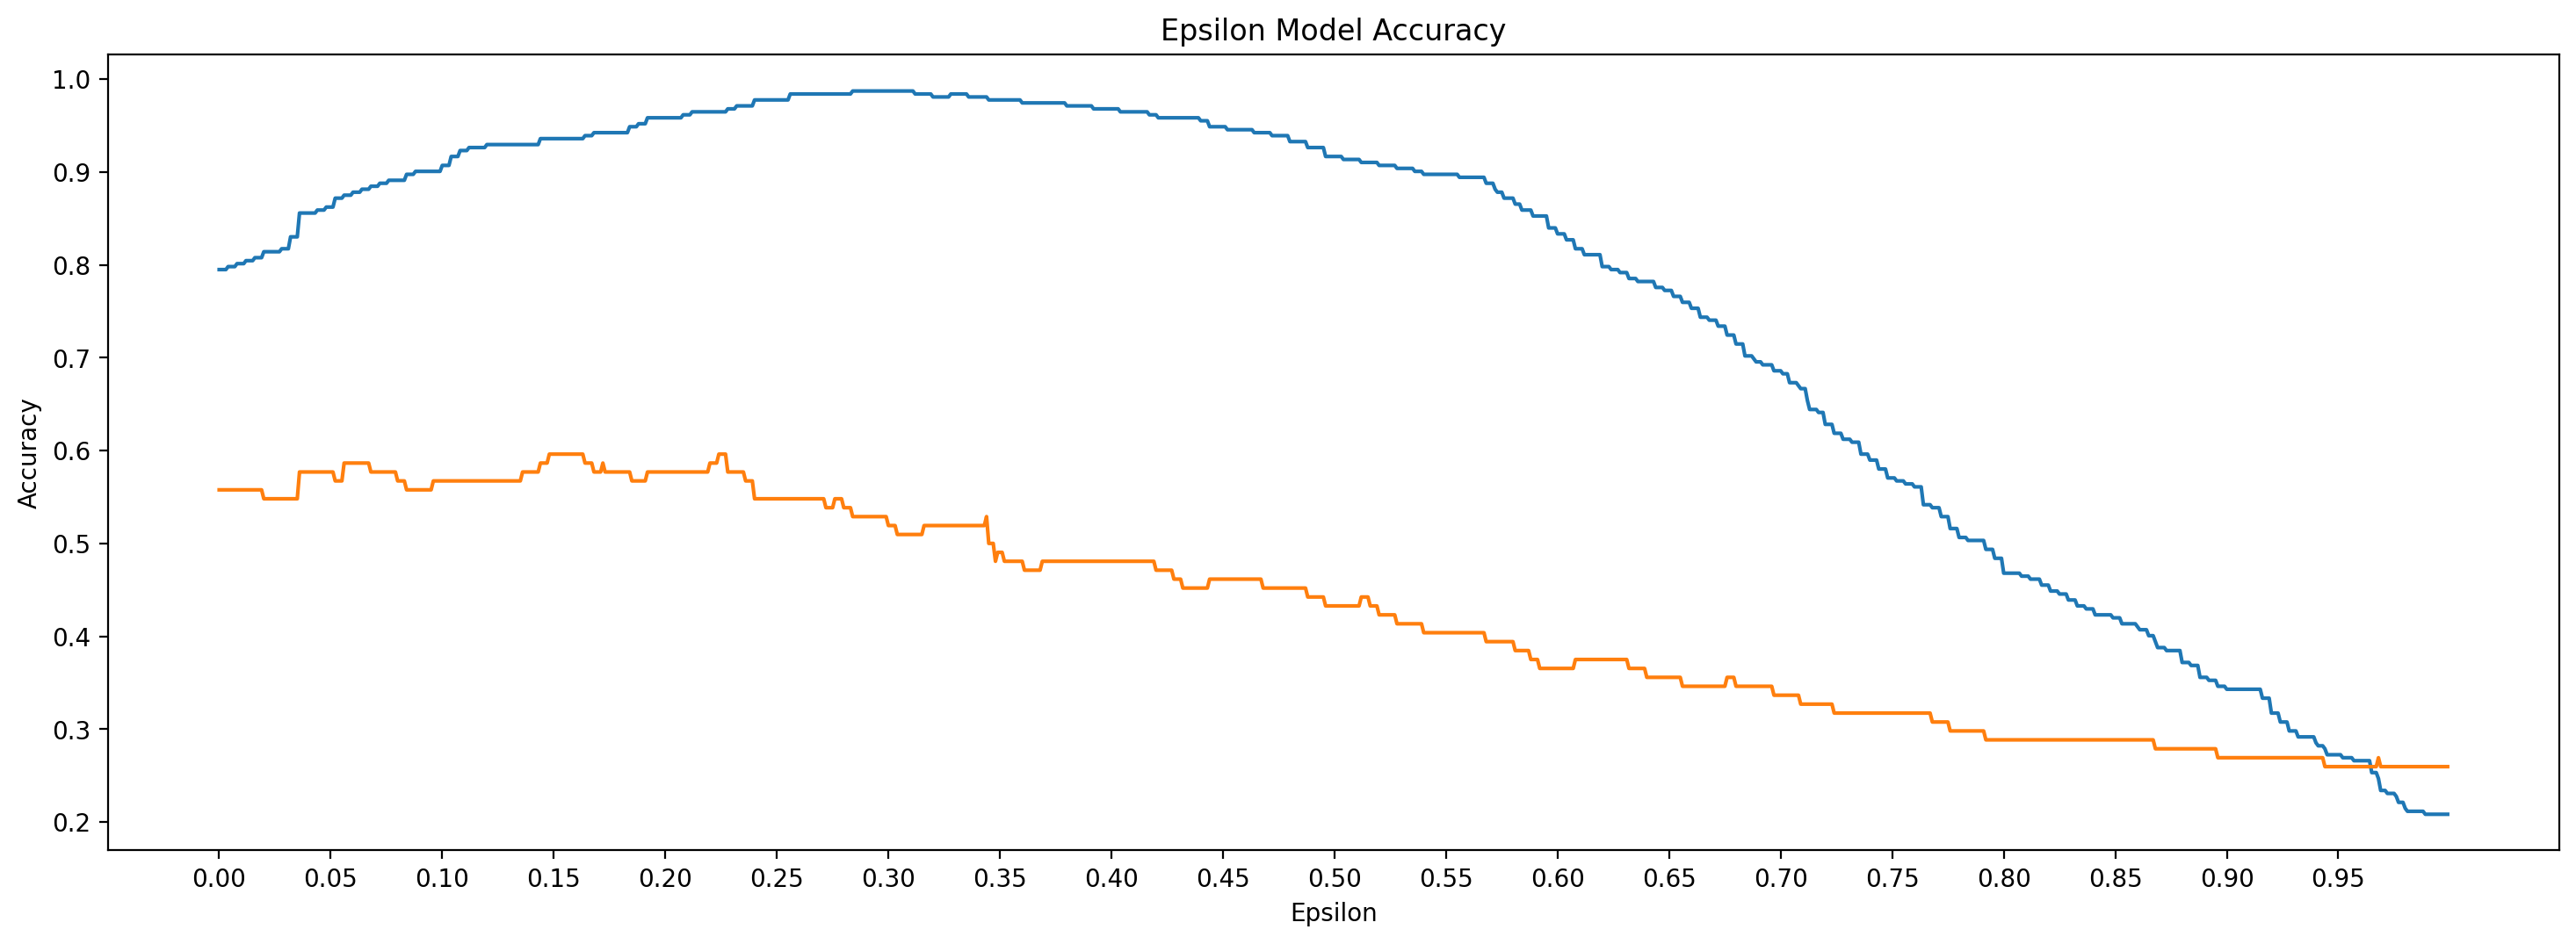

In [35]:
ticks = []
for i in range(0,20):
    ticks.append(i/20)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (18,6), dpi=200)
plt.plot(epsilons, model3_train_accuracies)
plt.plot(epsilons, model3_test_accuracies)
plt.xticks(ticks = ticks)
plt.title('Epsilon Model Accuracy')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')

## <div class='exercise'>Fifth Model: Random Forest</div> 

In [36]:
cvmeans = []
train_scores = []
for d in range(20):
    rf = RandomForestClassifier(max_depth = d+1,
                               max_features = 'sqrt',
                               oob_score = False,
                               random_state = 0,
                               n_estimators = n_trees)
   

    rf.fit(X_train, y_train)
    train_scores.append(dtree.score(X_train, y_train))
    cvscores = cross_val_score(dtree, X_train, y_train, cv=5)
    cvmeans.append(cvscores.mean())


Text(0, 0.5, 'Accuracy')

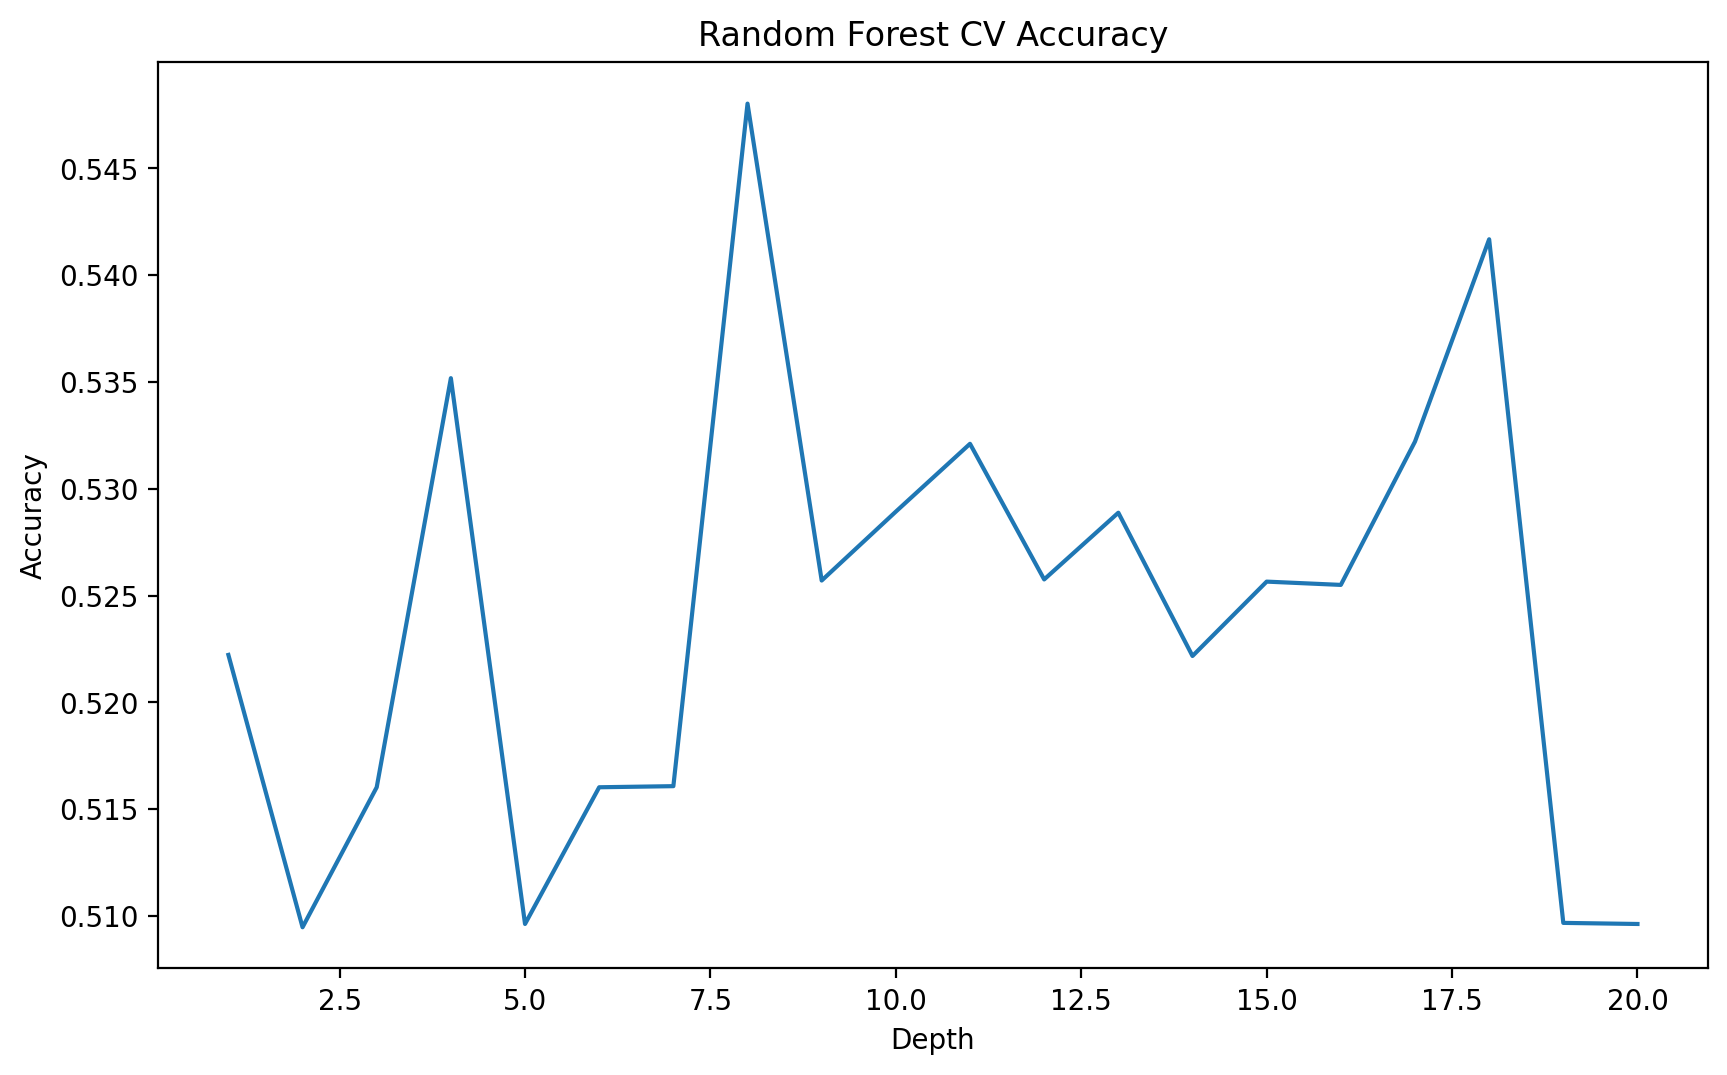

In [37]:
plt.figure(figsize=(10,6), dpi=200)
plt.plot(range(1,21), cvmeans)
plt.title('Random Forest CV Accuracy')
plt.xlabel('Depth')
plt.ylabel('Accuracy')

In [38]:
# Train the best model
best_depth = np.argmax(cvmeans)+1
rf = RandomForestClassifier(max_depth = best_depth,
                           max_features = 'sqrt',
                           oob_score = False,
                           random_state = 0,
                           n_estimators = n_trees)
rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=8, max_features='sqrt', n_estimators=250,
                       random_state=0)

In [39]:
# Evaluate results
random_forest_train_score = rf.score(X_train, y_train)
random_forest_test_score = rf.score(X_test, y_test)

In [40]:
# Print results summary
print(
    "The random forest of depth-{} and {} trees achieves the "
    "following accuracy scores:\n\n\ttrain\t{:.4f}\n\tTEST\t{:.4f}"
    .format(
        tree_depth,
        n_trees,
        random_forest_train_score,
        random_forest_test_score,
    )
)

The random forest of depth-16 and 250 trees achieves the following accuracy scores:

	train	0.9936
	TEST	0.5962


In [41]:
MODEL_NAME.append('Random Forest, depth = ' + str(best_depth))
TRAIN_SCORE.append(random_forest_train_score)
TEST_SCORE.append(random_forest_test_score)

## <div class='exercise'>Conclusion: Choice of the Model</div> 

In [42]:
MODELS_df = pd.DataFrame()
MODELS_df['Model'] = MODEL_NAME
MODELS_df['Train Score'] = TRAIN_SCORE
MODELS_df['Test Score'] = TEST_SCORE
display(MODELS_df)

,Model,Train Score,Test Score
0,Logistic Regression,0.554,0.529
1,Threshold = 0.029,0.554,0.529
2,"Decision Tree, depth = 16",1.000,0.548
3,"Bagging Decision Tree, depth = 16",0.862,0.577
4,"Random Forest, depth = 8",0.994,0.596


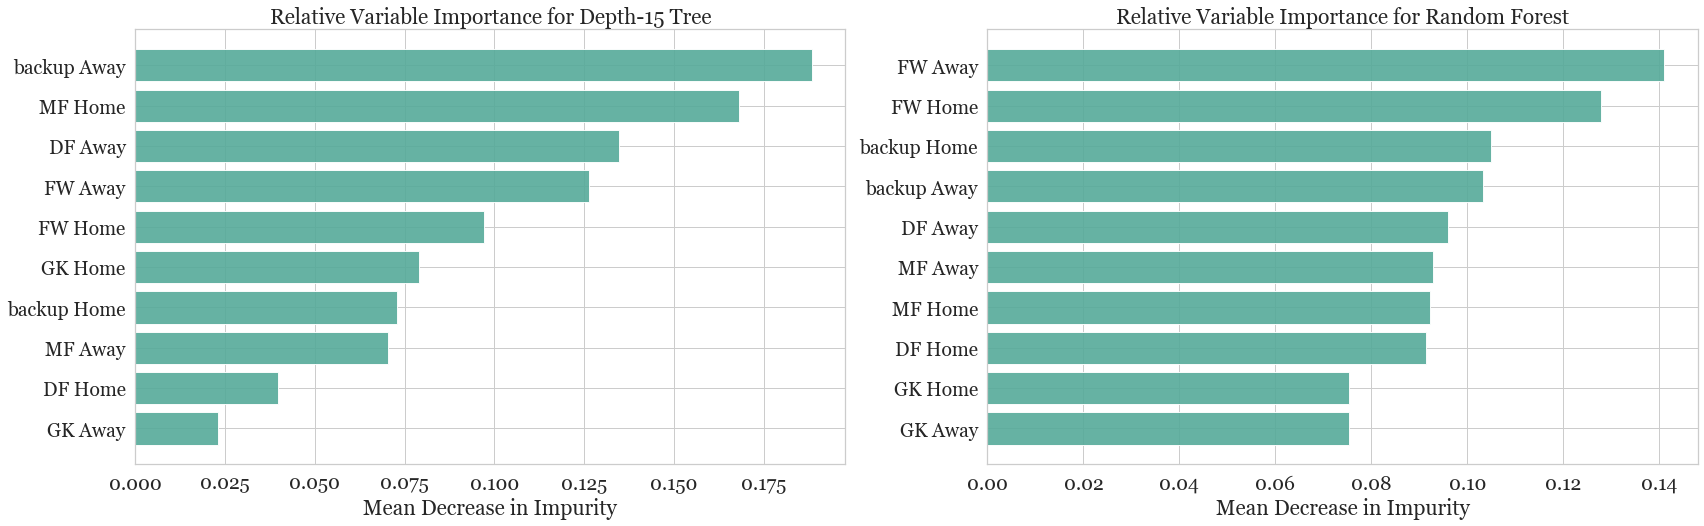

In [43]:
sns.set_theme(style='whitegrid', font='georgia', palette="dark:#5A9_r", font_scale = 1.75)
fig, axs = plt.subplots(1,2, figsize=(28,8))
models = {'Depth-15 Tree': dtree, 'Random Forest': rf} 
num_features = 10 
for i, (name, model) in enumerate(models.items()):
    importances = model.feature_importances_
    order = np.argsort(importances)[-num_features:]
    axs[i].barh(range(num_features), importances[order], tick_label=X_train.columns[order], alpha=0.9);
    axs[i].set_title(f"Relative Variable Importance for {name}")
    axs[i].set_xlabel("Mean Decrease in Impurity")
fig.savefig('test.png')

In [44]:
perm = PermutationImportance(rf, random_state=109, n_iter=10).fit(X_test, y_test)
display(eli5.show_weights(perm, feature_names=X_train.columns.tolist()))

Weight,Feature
0.0712 ± 0.0324,FW Home
0.0500 ± 0.0595,FW Away
0.0385 ± 0.0285,DF Home
0.0365 ± 0.0363,MF Home
0.0327 ± 0.0261,backup Home
0.0231 ± 0.0405,GK Away
0.0115 ± 0.0331,backup Away
0.0067 ± 0.0273,GK Home
0.0000 ± 0.0258,MF Away
-0.0010 ± 0.0303,DF Away


In [45]:
perm = PermutationImportance(dtree, random_state=109, n_iter=10).fit(X_test, y_test)
display(eli5.show_weights(perm, feature_names=X_train.columns.tolist()))

Weight,Feature
0.1240 ± 0.0781,FW Away
0.1231 ± 0.0582,MF Home
0.0298 ± 0.0264,MF Away
0.0288 ± 0.0403,FW Home
0.0288 ± 0.0394,backup Away
0.0269 ± 0.0595,DF Away
0.0202 ± 0.0327,DF Home
0.0154 ± 0.0231,backup Home
0.0096 ± 0.0172,GK Away
-0.0192 ± 0.0394,GK Home


We choose the random forest.

If you want to use it, just do rf.predict()


The models we tried:
1) Simple Logistic Regression = 0.529
2) Threshold Model we created = 0.529
3) Simple Decision Tree = 0.577
3) Decision Tree with Bagging = 0.577
4) Random Forest = 0.596

Note that this is not a binary classification problem. We have three classes.

If you want to use rf to make binary choices, you can look at rf.predict_proba(X) and choose the higher probability among 2 and 0.\
Note that 2 means home wins, 1 means draw, 0 means away wins.